In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import seaborn as sns

In [2]:
database = 'kinara.db'
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,loan_information,loan_information,2,"CREATE TABLE ""loan_information"" (\n""loan_id"" I..."
1,table,enteprise_information,enteprise_information,4,"CREATE TABLE ""enteprise_information"" (\n""enter..."
2,table,scores_information,scores_information,8,"CREATE TABLE ""scores_information"" (\n""loan_id""..."
3,table,disbursements_information,disbursements_information,10,"CREATE TABLE ""disbursements_information"" (\n""a..."


In [3]:
loan_information = pd.read_sql("""SELECT *
                        FROM loan_information""", conn)
loan_information.sample(5)

,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id
918,9532,TLWCU0001514,20134,7067,2017-03-22,TLWCU,33
330,8936,TLWCU0001426,18609,6539,2017-03-13,TLWCU,22
2376,11007,TLWCU0002026,24164,8423,2017-05-22,TLWCU,69
1652,10279,TLWCU0001872,22021,7726,2017-04-21,TLWCU,35
2658,15931,None,37145,12711,2017-05-23,None,40


In [4]:
enteprise_information = pd.read_sql("""SELECT *
                        FROM enteprise_information""", conn)
enteprise_information.sample(5)

,enterprise_id,business_type,business_activity,business_sector
1705,7750,Manufacturing,Sales,Auto Components
107,1018,Manufacturing,Sales,Wood
1690,7735,Trading,Retail,Electricals
193,1849,Manufacturing,Job Work,Auto Components
1226,7215,Manufacturing,Sales,Medical Equipment


In [5]:
scores_information = pd.read_sql("""SELECT *
                        FROM scores_information""", conn)
scores_information.sample(5)

,loan_id,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP
526,9284,24,Cash & Non Banked,696
1290,10287,32,Cash & Non Banked,757
211,8872,41,Cash & Non Banked,776
665,9458,31,Invoice & Banked,802
180,8831,41,Cash & Non Banked,636


In [6]:
disbursements_information = pd.read_sql("""SELECT *
                        FROM disbursements_information""", conn)
disbursements_information.sample(5)

,account_number,net_disbursement_magnitude,transaction_Date
863,TLWCU0001723,227309.0,2017-04-29
606,TLWCS0000887,88882.0,2017-03-31
835,TLWCU0001722,179783.0,2017-04-29
534,TLWCU0001622,460889.0,2017-03-31
1561,TLWCU0002912,923576.0,2017-07-31


In [7]:
cur=conn.cursor()

# Merging Tables using SQL

In [8]:
sql_command = """SELECT L.loan_id, L.account_number, L.customer_id, L.enterprise_id, L.screening_date, L.product_code, L.hub_id,
                S.ManagAgeui_APP, S.BusinFormalityOfTheBusinessui, S.ManagCBscoreui_APP,
                DI.net_disbursement_magnitude, DI.transaction_Date,
                EI.business_type, EI.business_activity, EI.business_sector
                FROM loan_information  L 
                LEFT JOIN scores_information S
                ON S.loan_id == L.loan_id
                LEFT JOIN disbursements_information DI
                ON DI.account_number == L.account_number
                LEFT JOIN enteprise_information EI
                ON EI.enterprise_id == L.enterprise_id
                ;"""
full_database = pd.read_sql(sql_command,conn)

In [9]:
full_database.head()

,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,net_disbursement_magnitude,transaction_Date,business_type,business_activity,business_sector
0,5692,TLMFS0000055,17850,6278,2017-03-07,TLMFS,46,32,Cash & Non Banked,0,345909.0,2017-02-28,Manufacturing,Job Work,Auto Components
1,6190,TLWCU0001219,17857,6280,2017-03-07,TLWCU,32,35,Cash & Non Banked,0,144157.0,2017-02-28,Trading,Retail,Book Stores
2,6191,TLAPS0000292,9481,2916,2017-03-07,TLAPS,32,32,Cash & Non Banked,0,484931.0,2017-03-23,Manufacturing,Sales,Electricals
3,6192,LCRIU0000019,6597,32,2017-03-10,LCRIU,32,None,None,None,683859.0,2017-03-13,Manufacturing,Job Work & Sales,Auto Components
4,6193,LCRIU0000020,9732,3167,2017-03-13,LCRIU,32,39,Cash & Non Banked,548,896703.0,2017-03-15,Manufacturing,Job Work,Auto Components


# Check:

In [10]:
u1 = full_database.enterprise_id.unique()
u2 = enteprise_information.enterprise_id.unique()
for i in u2:
    if i not in u1:
        print('wrong')

In [11]:
d1 = full_database.loan_id.unique()
d2 = loan_information.loan_id.unique()
for i in d2:
    if i not in d1:
        print('wrong')

In [12]:
a1 = full_database.loan_id.unique()
a2 = scores_information.loan_id.unique()
for i in d2:
    if i not in d1:
        print('wrong')

In [13]:
r1 = full_database.account_number.unique()
r2 = disbursements_information.account_number.unique()
for i in r2:
    if i not in r1:
        print('wrong')

# Removing Missing Values and Converting string to float/int whenever required

In [14]:
len(full_database.account_number.unique())

1548

In [15]:
len(full_database.account_number)

2692

In [16]:
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 15 columns):
loan_id                          2692 non-null int64
account_number                   1577 non-null object
customer_id                      2692 non-null int64
enterprise_id                    2692 non-null int64
screening_date                   2692 non-null object
product_code                     1636 non-null object
hub_id                           2692 non-null int64
ManagAgeui_APP                   1987 non-null object
BusinFormalityOfTheBusinessui    2061 non-null object
ManagCBscoreui_APP               1987 non-null object
net_disbursement_magnitude       1575 non-null float64
transaction_Date                 1575 non-null object
business_type                    2692 non-null object
business_activity                2692 non-null object
business_sector                  2690 non-null object
dtypes: float64(1), int64(4), object(10)
memory usage: 315.5+ KB


### Replacing missing ManagAgeui_APP with mean

In [17]:
mean = full_database.ManagAgeui_APP.values
new_mean = list()
for i in mean:
    try:
        new_mean.append(int(i))
    except:
        continue
mean = sum(new_mean)/len(new_mean)

In [18]:
full_database.ManagAgeui_APP.fillna(mean,inplace=True)
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 15 columns):
loan_id                          2692 non-null int64
account_number                   1577 non-null object
customer_id                      2692 non-null int64
enterprise_id                    2692 non-null int64
screening_date                   2692 non-null object
product_code                     1636 non-null object
hub_id                           2692 non-null int64
ManagAgeui_APP                   2692 non-null object
BusinFormalityOfTheBusinessui    2061 non-null object
ManagCBscoreui_APP               1987 non-null object
net_disbursement_magnitude       1575 non-null float64
transaction_Date                 1575 non-null object
business_type                    2692 non-null object
business_activity                2692 non-null object
business_sector                  2690 non-null object
dtypes: float64(1), int64(4), object(10)
memory usage: 315.5+ KB


### Replacing with mode

In [19]:
data = Counter(full_database.BusinFormalityOfTheBusinessui.values)
data.most_common(1)

[('Cash & Non Banked', 1356)]

In [20]:
full_database.BusinFormalityOfTheBusinessui.fillna('Cash & Non Banked',inplace = True)

In [21]:
full_database.business_sector.values

array(['Auto Components', 'Book Stores', 'Electricals', ..., 'General',
       'Machine  Components', 'Textiles'], dtype=object)

In [22]:
dat = Counter(full_database.business_sector.values)
dat.most_common(1)

[('Auto Components', 404)]

In [23]:
full_database.business_sector.fillna('Auto Components',inplace=True)

### Missing cibil scores are set to 0

In [24]:
full_database.ManagCBscoreui_APP = full_database.ManagCBscoreui_APP.fillna(0)

### Conversion to int

In [25]:
def encode_net_disbursement_magnitude(value):
    try:
        value = int(value)
        return 1
    except:
        return 0
full_database.net_disbursement_magnitude = full_database.net_disbursement_magnitude.apply(lambda x: encode_net_disbursement_magnitude(x))

In [26]:
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 15 columns):
loan_id                          2692 non-null int64
account_number                   1577 non-null object
customer_id                      2692 non-null int64
enterprise_id                    2692 non-null int64
screening_date                   2692 non-null object
product_code                     1636 non-null object
hub_id                           2692 non-null int64
ManagAgeui_APP                   2692 non-null object
BusinFormalityOfTheBusinessui    2692 non-null object
ManagCBscoreui_APP               2692 non-null object
net_disbursement_magnitude       2692 non-null int64
transaction_Date                 1575 non-null object
business_type                    2692 non-null object
business_activity                2692 non-null object
business_sector                  2692 non-null object
dtypes: int64(5), object(10)
memory usage: 315.5+ KB


# Collateral

In [27]:
def get_collateral(string):
    string = str(string)
    if string[-1] == 'U':
        return 'Unsecured'
    elif string[-1] == 'S':
        return "Secured"
    return 'Unknown'
full_database['collateral'] = full_database.product_code.apply(lambda x: get_collateral(x))

In [28]:
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 16 columns):
loan_id                          2692 non-null int64
account_number                   1577 non-null object
customer_id                      2692 non-null int64
enterprise_id                    2692 non-null int64
screening_date                   2692 non-null object
product_code                     1636 non-null object
hub_id                           2692 non-null int64
ManagAgeui_APP                   2692 non-null object
BusinFormalityOfTheBusinessui    2692 non-null object
ManagCBscoreui_APP               2692 non-null object
net_disbursement_magnitude       2692 non-null int64
transaction_Date                 1575 non-null object
business_type                    2692 non-null object
business_activity                2692 non-null object
business_sector                  2692 non-null object
collateral                       2692 non-null object
dtypes: int64(5), object(11)
memor

In [29]:
full_database['year'] = full_database.screening_date.apply(lambda x: int(x[:4]))
full_database['month'] = full_database.screening_date.apply(lambda x: int(x[5:7]))
full_database['day'] = full_database.screening_date.apply(lambda x: int(x[8:]))


In [30]:
full_database.business_type.values

array(['Manufacturing', 'Trading', 'Manufacturing', ..., 'Trading',
       'Manufacturing', 'Manufacturing'], dtype=object)

### Exploratory Data Analysis

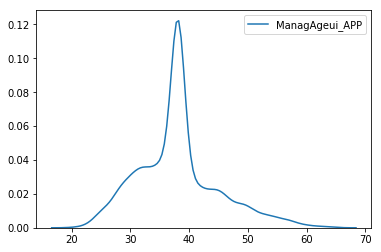

In [31]:
sns.kdeplot(full_database.ManagAgeui_APP)

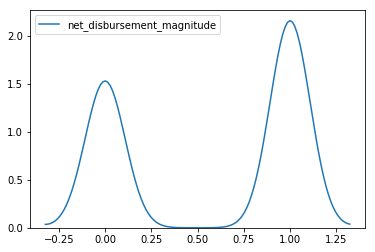

In [32]:
sns.kdeplot(full_database.query('net_disbursement_magnitude< 2000000').net_disbursement_magnitude)

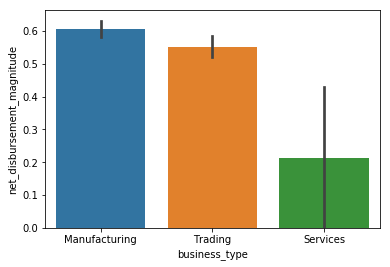

In [33]:
sns.barplot(x="business_type", y="net_disbursement_magnitude",data=full_database)
plt.show()

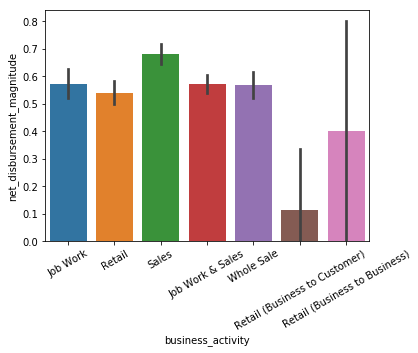

In [34]:
a = sns.barplot(x="business_activity", y="net_disbursement_magnitude",data=full_database)
a.figure.tight_layout()
a.set_xticklabels(a.get_xticklabels(),rotation=30)
plt.show()

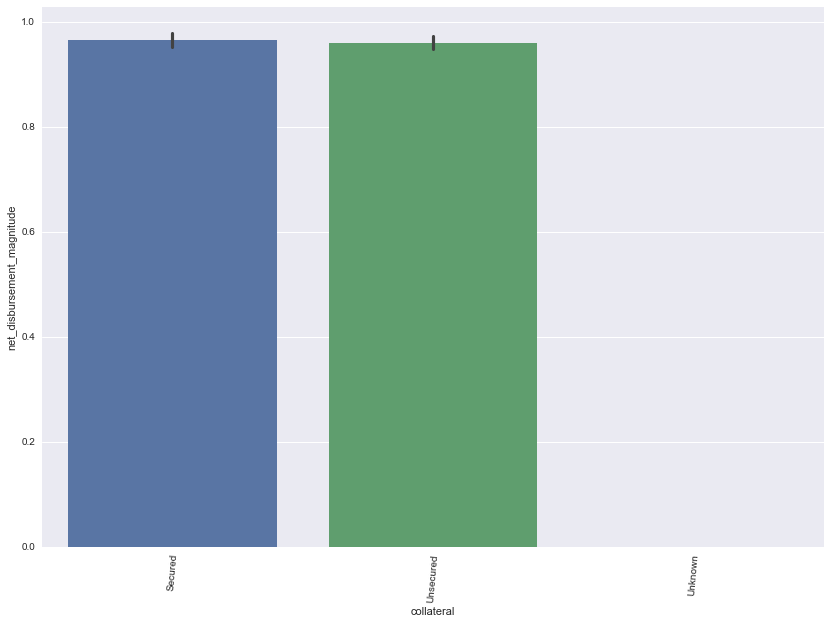

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
a = sns.barplot(x="collateral", y="net_disbursement_magnitude",data=full_database)
a.figure.tight_layout()
a.set_xticklabels(a.get_xticklabels(),rotation=85)
plt.show()

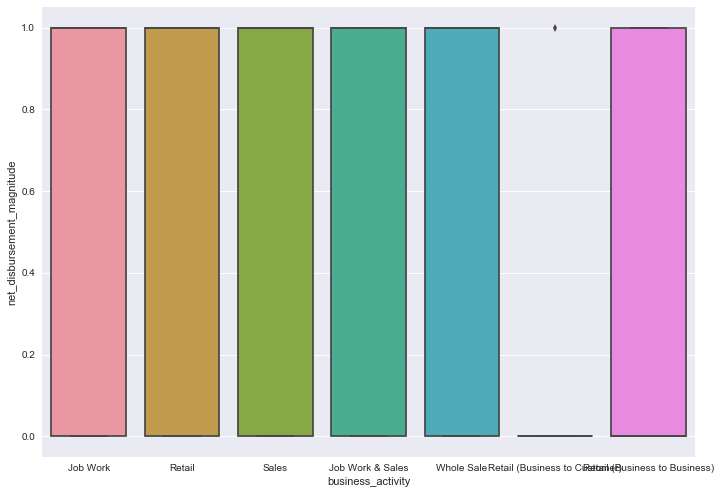

In [36]:
sns.boxplot(x="business_activity", y="net_disbursement_magnitude",data=full_database)
plt.show()

In [37]:
relevant_columns = ['ManagAgeui_APP','BusinFormalityOfTheBusinessui','ManagCBscoreui_APP','net_disbursement_magnitude',
                   'business_type','business_activity','business_sector','year','month','day','collateral']

In [38]:
full_database = full_database[relevant_columns]

In [39]:
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 11 columns):
ManagAgeui_APP                   2692 non-null object
BusinFormalityOfTheBusinessui    2692 non-null object
ManagCBscoreui_APP               2692 non-null object
net_disbursement_magnitude       2692 non-null int64
business_type                    2692 non-null object
business_activity                2692 non-null object
business_sector                  2692 non-null object
year                             2692 non-null int64
month                            2692 non-null int64
day                              2692 non-null int64
collateral                       2692 non-null object
dtypes: int64(4), object(7)
memory usage: 231.4+ KB


In [40]:
full_database.ManagAgeui_APP = full_database.ManagAgeui_APP.apply(lambda x: float(x))

In [41]:
temp = pd.get_dummies(full_database.BusinFormalityOfTheBusinessui)

In [42]:
full_database = pd.concat([full_database,temp],axis = 1)

In [43]:
full_database.ManagCBscoreui_APP = full_database.ManagCBscoreui_APP.apply(lambda x: int(x))

In [44]:
temp = pd.get_dummies(full_database.business_type)
full_database = pd.concat([full_database,temp],axis = 1)

In [45]:
def others(string):
    if string in ['Auto Components','Food Products','Textiles','Plastics','Fashion','Fabrication','Food & Beverage','Machine  Components']:
        return string
    return 'Others'

In [46]:
full_database.business_sector = full_database.business_sector.apply(lambda x: others(x))

In [47]:
temp = pd.get_dummies(full_database.business_sector)
full_database = pd.concat([full_database,temp],axis = 1)
temp = pd.get_dummies(full_database.business_activity)
full_database = pd.concat([full_database,temp],axis = 1)
temp = pd.get_dummies(full_database.collateral)
full_database = pd.concat([full_database,temp],axis = 1)

In [48]:
full_database.drop(['BusinFormalityOfTheBusinessui','business_type','business_activity','business_sector','collateral'],axis = 1, inplace = True)

In [49]:
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 32 columns):
ManagAgeui_APP                   2692 non-null float64
ManagCBscoreui_APP               2692 non-null int64
net_disbursement_magnitude       2692 non-null int64
year                             2692 non-null int64
month                            2692 non-null int64
day                              2692 non-null int64
Cash & Banked                    2692 non-null uint8
Cash & Non Banked                2692 non-null uint8
Invoice & Banked                 2692 non-null uint8
Invoice & Non Banked             2692 non-null uint8
Manufacturing                    2692 non-null uint8
Services                         2692 non-null uint8
Trading                          2692 non-null uint8
Auto Components                  2692 non-null uint8
Fabrication                      2692 non-null uint8
Fashion                          2692 non-null uint8
Food & Beverage                  2692 non-n

In [50]:
#Cibil scores

def get_bins(value):
    if value < 200:
        return -1
    elif 200 < value < 650:
        return 0
    else:
        return 1

In [51]:
full_database.ManagCBscoreui_APP = full_database.ManagCBscoreui_APP.apply(lambda x: get_bins(int(x)))

In [52]:
full_database.head()

,ManagAgeui_APP,ManagCBscoreui_APP,net_disbursement_magnitude,year,month,day,Cash & Banked,Cash & Non Banked,Invoice & Banked,Invoice & Non Banked,...,Job Work,Job Work & Sales,Retail,Retail (Business to Business),Retail (Business to Customer),Sales,Whole Sale,Secured,Unknown,Unsecured
0,32.000000,-1,1,2017,3,7,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,35.000000,-1,1,2017,3,7,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,32.000000,-1,1,2017,3,7,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,38.090086,-1,1,2017,3,10,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,39.000000,0,1,2017,3,13,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [53]:
len(full_database)

2692

# Random Forest

In [54]:
full_database = full_database.sample(frac=1)

In [55]:
train = full_database[:2000]
test = full_database[2000:]

train_x = train.drop(['net_disbursement_magnitude'],axis = 1)
train_y = train['net_disbursement_magnitude']

test_x = test.drop(['net_disbursement_magnitude'],axis = 1)
test_y = test['net_disbursement_magnitude']
rf = RandomForestClassifier()
rf.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Feature Importance

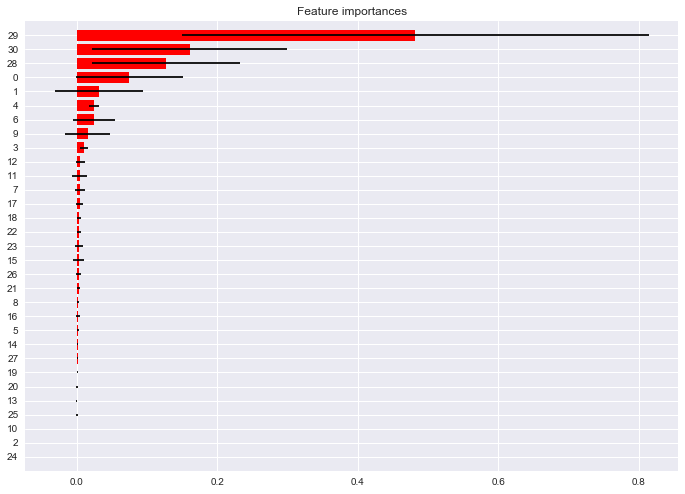

In [56]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(train_x.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.

plt.yticks(range(train_x.shape[1]), indices)
plt.ylim([-1, train_x.shape[1]])
plt.show()

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
predictions = rf.predict(test_x)

# Accuracy of Random Forest Model

In [59]:
accuracy_score(test_y,predictions)

0.9710982658959537